In [50]:
import pandas as pd
raw_df = pd.read_json("data/timestamps.json")
raw_df.head()

,task_id,task_name,topic,user_id,timestamp,is_solution
0,347,Debugging Variable Names,How To Use Variables,1,2024-11-12 01:19:17.909748,True
1,74,Complex Commenting Out,How To Write Comments,1,2024-11-12 01:20:34.772068,True
2,748,Using 'from ... import' Syntax,How To Import Modules,11,2024-11-12 01:22:45.950607,True
3,650,Multiple Assignment,How To Use Variables,11,2024-11-12 02:55:40.900590,True
4,650,Multiple Assignment,How To Use Variables,11,2024-11-12 02:56:00.925254,True


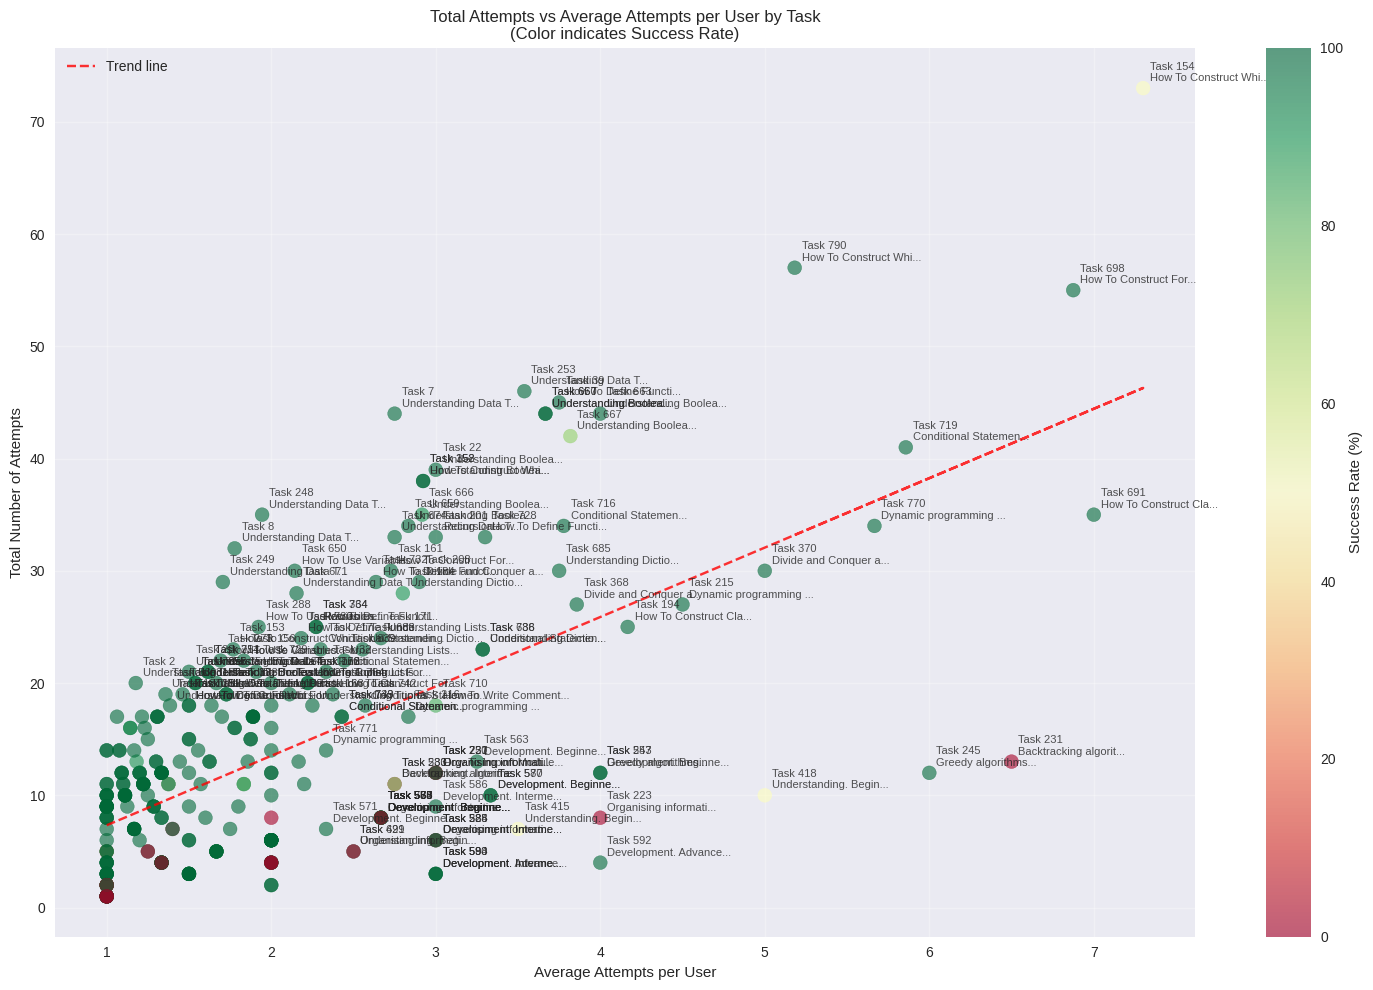


Tasks with Notable Patterns:
     task_id                         topic  total_attempts  avg_attempts  success_rate
39       154  How To Construct While Loops              73          7.30         50.00
309      790  How To Construct While Loops              57          5.18        100.00
260      698    How To Construct For Loops              55          6.88        100.00
121      253      Understanding Data Types              46          3.54        100.00
19        39       How To Define Functions              45          3.75        100.00
235      660   Understanding Boolean Logic              44          3.67        100.00
233      657   Understanding Boolean Logic              44          3.67        100.00
236      663   Understanding Boolean Logic              44          4.00        100.00
3          7      Understanding Data Types              44          2.75        100.00
238      667   Understanding Boolean Logic              42          3.82         72.73


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

task_metrics = []
for (task_id, task_name), group in raw_df.groupby(['task_id', 'task_name']):
    total_attempts = len(group)   
    total_users = group['user_id'].nunique()
    avg_attempts = total_attempts / total_users
    
    # Calculate success rate
    successful_users = group[group['is_solution']]['user_id'].nunique()
    success_rate = (successful_users / total_users) * 100 if total_users > 0 else 0
    
    task_metrics.append({
        'task_id': task_id,
        'topic': group['topic'].iloc[0],
        'total_attempts': total_attempts,
        'avg_attempts': avg_attempts,
        'total_users': total_users,
        'success_rate': success_rate
    })

df = pd.DataFrame(task_metrics)
plt.figure(figsize=(15, 10))

scatter = plt.scatter(df['avg_attempts'], df['total_attempts'], 
                     c=df['success_rate'], cmap='RdYlGn',
                     s=100, alpha=0.6)
plt.colorbar(scatter, label='Success Rate (%)')

plt.xlabel('Average Attempts per User')
plt.ylabel('Total Number of Attempts')
plt.title('Total Attempts vs Average Attempts per User by Task\n(Color indicates Success Rate)')

for idx, row in df.iterrows():
    if row['total_attempts'] > df['total_attempts'].quantile(0.75) or row['avg_attempts'] > df['avg_attempts'].quantile(0.75):
        plt.annotate(f"Task {row['task_id']}\n{row['topic'][:20]}...",
                    (row['avg_attempts'], row['total_attempts']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.8)

z = np.polyfit(df['avg_attempts'], df['total_attempts'], 1)
p = np.poly1d(z)
plt.plot(df['avg_attempts'], p(df['avg_attempts']), "r--", alpha=0.8, 
         label=f'Trend line')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/task_attempts_scatter.png', dpi=300, bbox_inches='tight')

plt.show()

print("\nTasks with Notable Patterns:")
notable_tasks = df[
    (df['total_attempts'] > df['total_attempts'].mean()) | 
    (df['avg_attempts'] > df['avg_attempts'].mean())
].sort_values('total_attempts', ascending=False).head(10)

print(notable_tasks[['task_id', 'topic', 'total_attempts', 'avg_attempts', 'success_rate']]
      .round(2)
      .to_string())

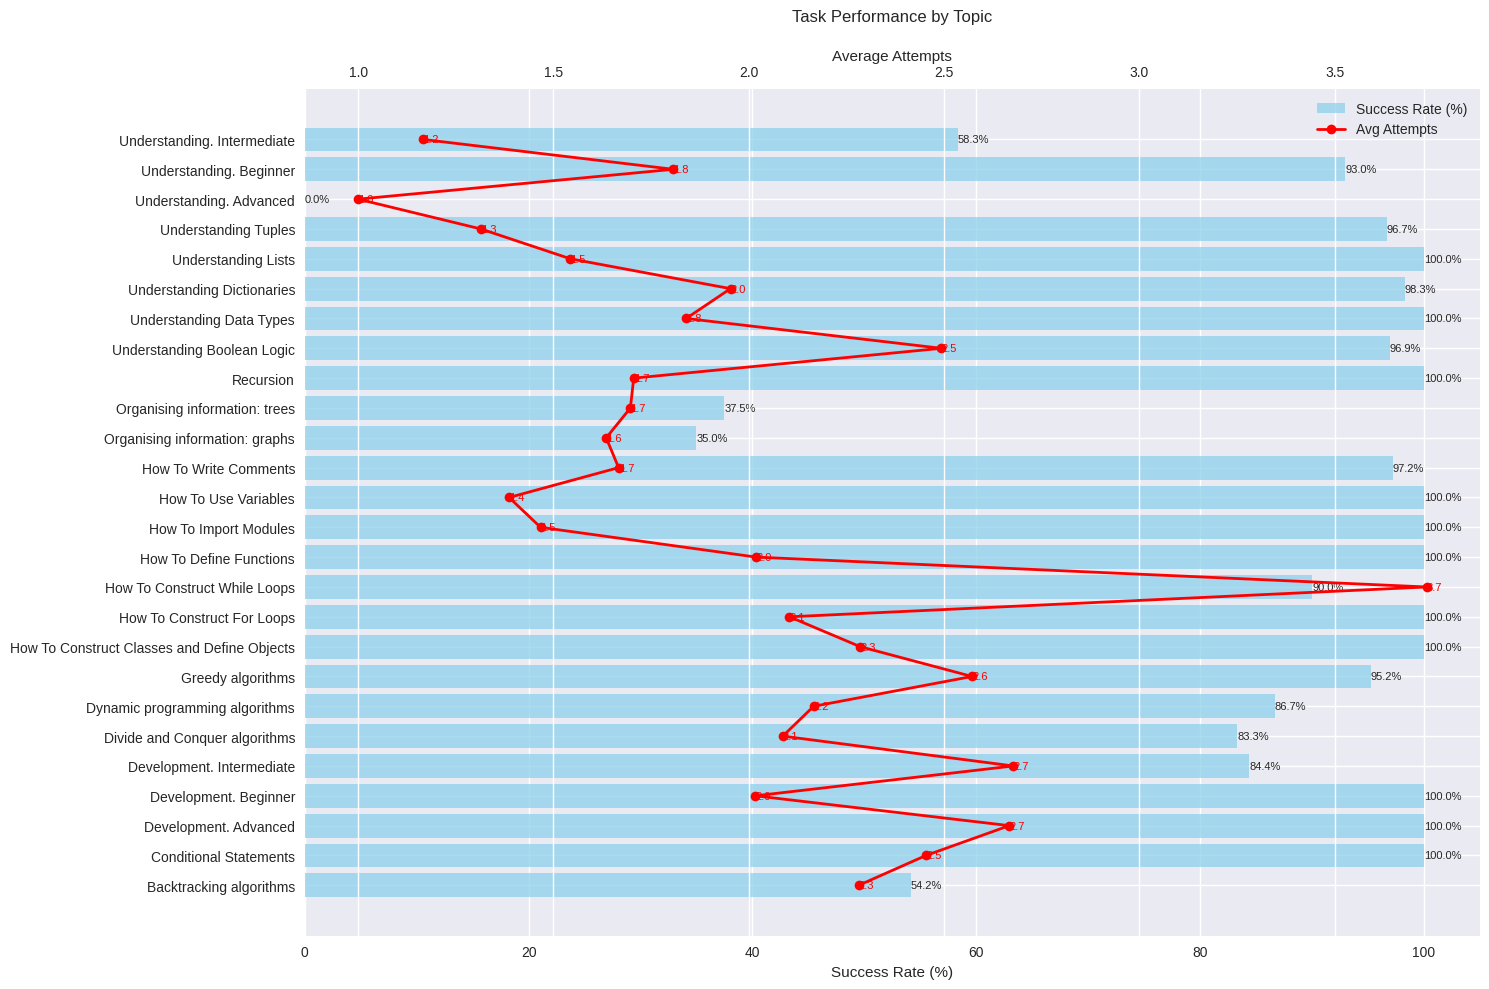


Topic Statistics:
                                             success_rate  avg_attempts  total_users
topic                                                                               
Backtracking algorithms                             54.17          2.28            4
Conditional Statements                             100.00          2.45            8
Development. Advanced                              100.00          2.67            1
Development. Beginner                              100.00          2.02            3
Development. Intermediate                           84.38          2.68            2
Divide and Conquer algorithms                       83.33          2.09            5
Dynamic programming algorithms                      86.67          2.17            5
Greedy algorithms                                   95.24          2.57            2
How To Construct Classes and Define Objects        100.00          2.28            5
How To Construct For Loops                    

In [52]:
topic_metrics = []
for topic, group in raw_df.groupby('topic'):
    tasks = group['task_id'].unique()
    
    task_metrics = []
    for task_id in tasks:
        task_data = group[group['task_id'] == task_id]
        total_users = task_data['user_id'].nunique()
        successful_users = task_data[task_data['is_solution']]['user_id'].nunique()
        total_attempts = len(task_data)
        
        if total_users > 0:
            success_rate = (successful_users / total_users) * 100
            avg_attempts = total_attempts / total_users
        else:
            success_rate = 0
            avg_attempts = 0
            
        task_metrics.append({
            'success_rate': success_rate,
            'avg_attempts': avg_attempts,
            'total_users': total_users
        })
    
    topic_stats = pd.DataFrame(task_metrics).mean()
    topic_metrics.append({
        'topic': topic,
        'success_rate': topic_stats['success_rate'],
        'avg_attempts': topic_stats['avg_attempts'],
        'total_users': int(topic_stats['total_users'])
    })

topic_stats = pd.DataFrame(topic_metrics).set_index('topic')

plt.figure(figsize=(15, 10))
ax1 = plt.subplot(111)
bars = ax1.barh(topic_stats.index, topic_stats['success_rate'], 
                color='skyblue', alpha=0.7, label='Success Rate (%)')

ax2 = ax1.twiny()
line = ax2.plot(topic_stats['avg_attempts'], range(len(topic_stats.index)), 
                color='red', marker='o', label='Avg Attempts', linewidth=2)

ax1.set_xlabel('Success Rate (%)')
ax2.set_xlabel('Average Attempts')
ax1.set_title('Task Performance by Topic', pad=20)

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width, i, f'{width:.1f}%', 
             va='center', ha='left', fontsize=8)

for i, value in enumerate(topic_stats['avg_attempts']):
    ax2.text(value, i, f'{value:.1f}', 
             va='center', ha='left', color='red', fontsize=8)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()

print("\nTopic Statistics:")
print(topic_stats.round(2).to_string())

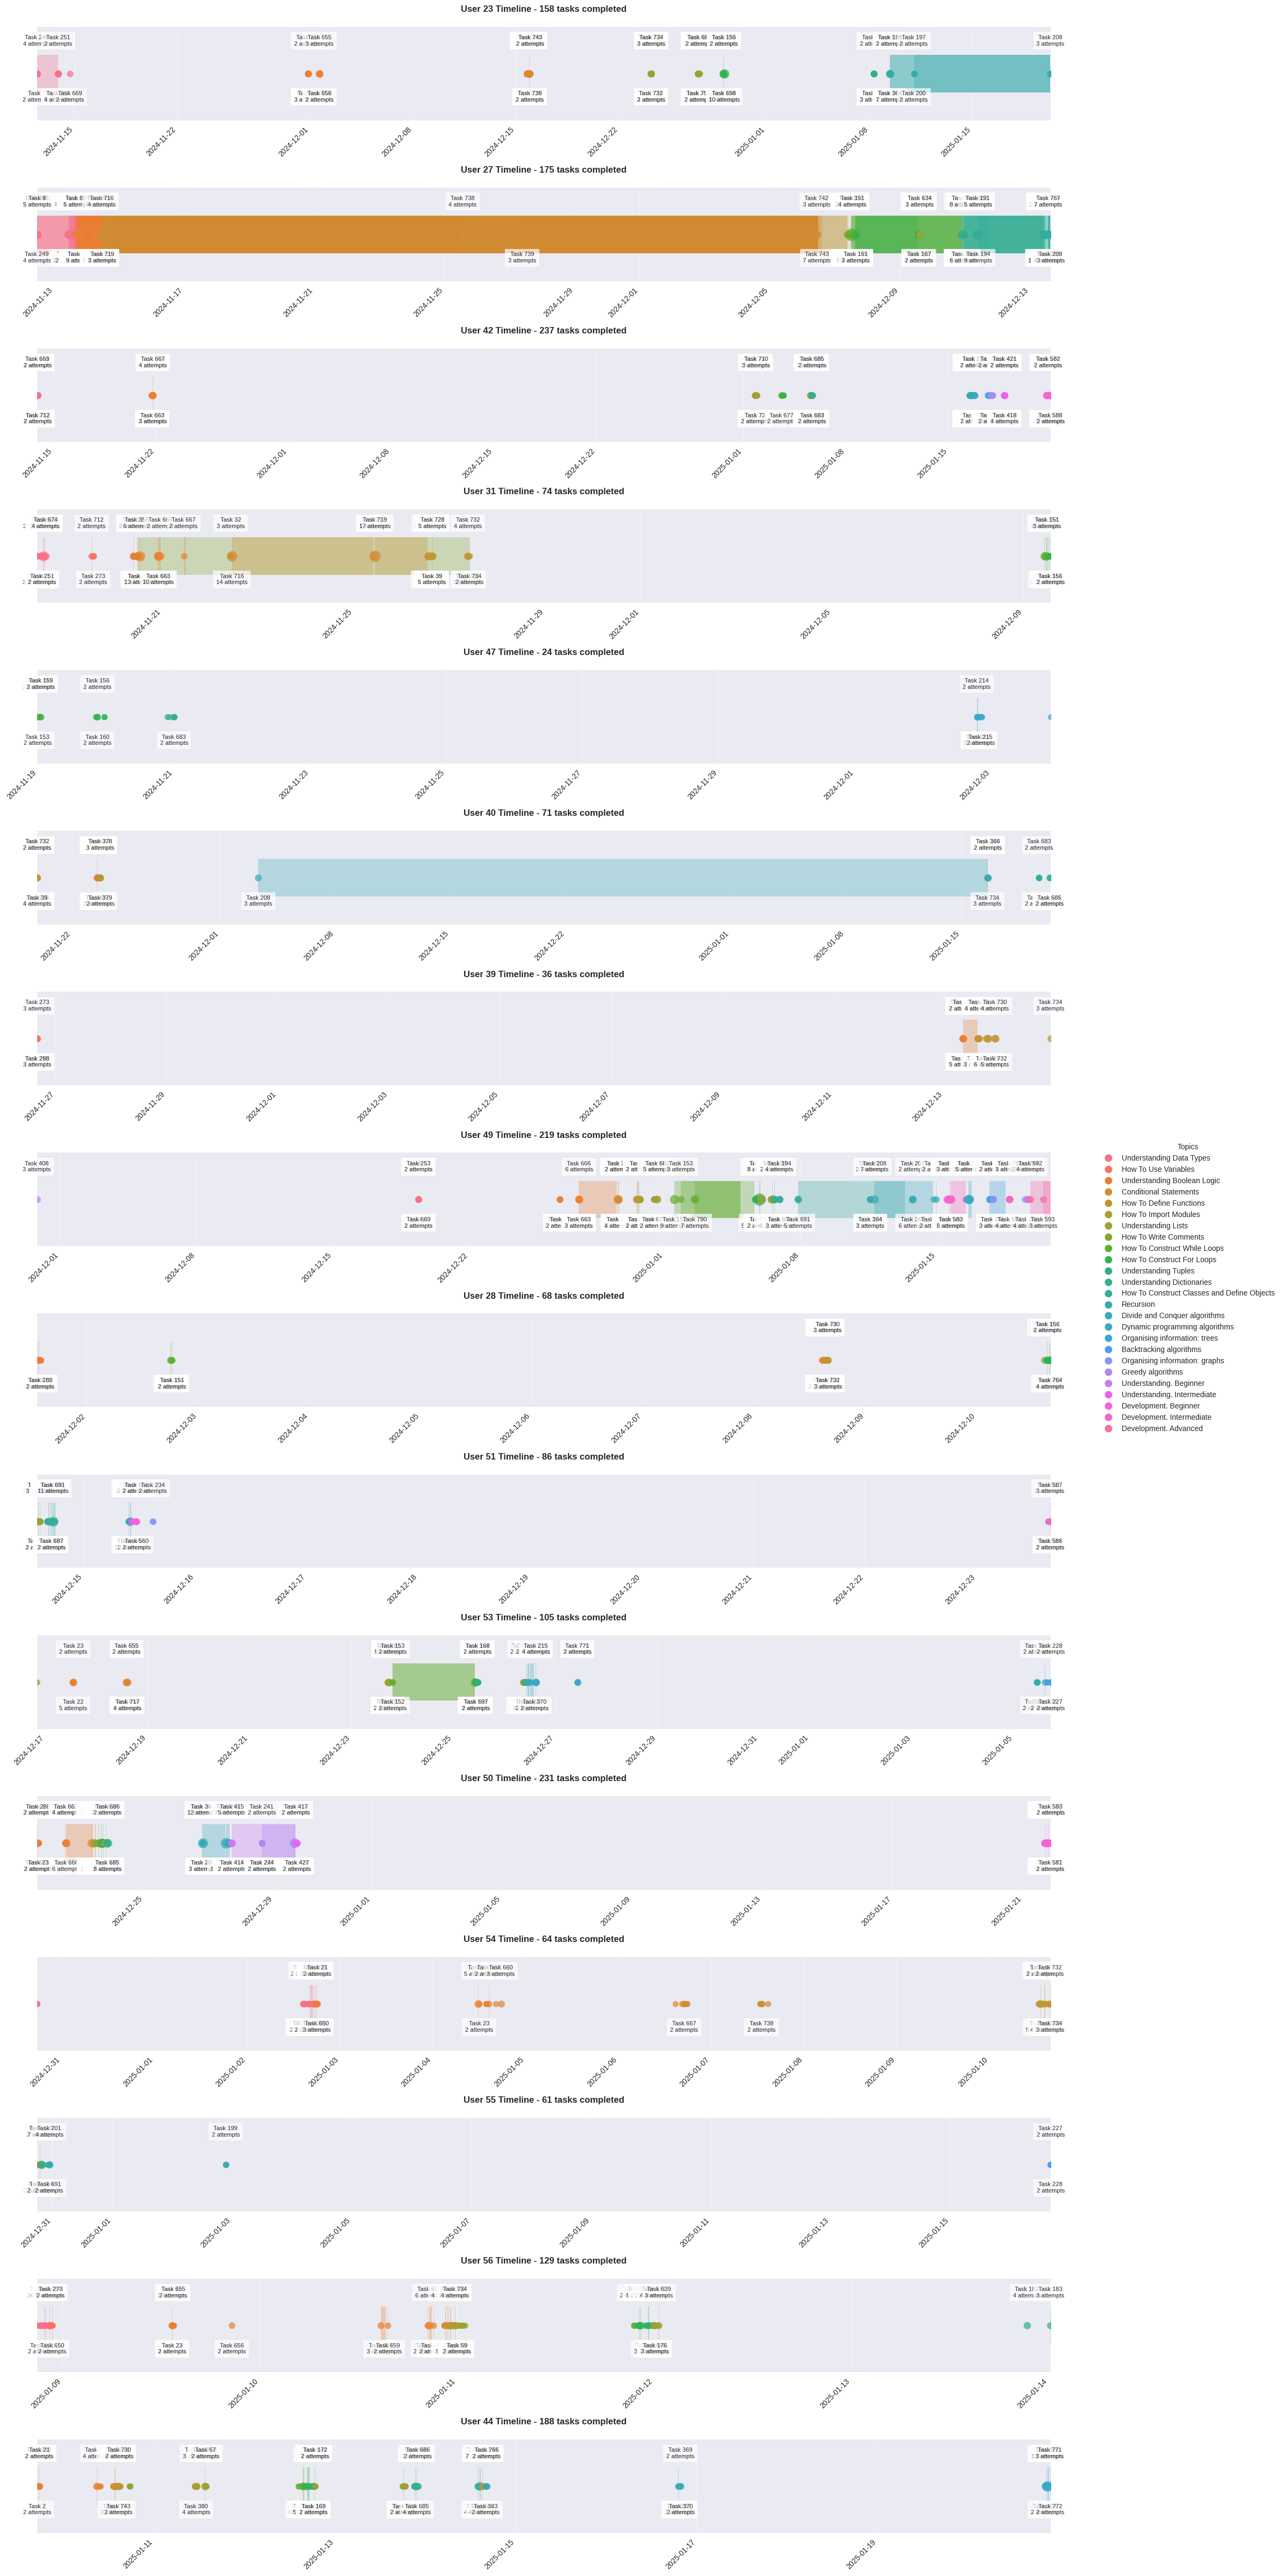


User Activity Summary:

User 23:
Tasks completed: 158
Active period: 68 days
Average attempts per task: 1.7
Most frequent topics: Understanding Lists, Understanding Tuples

User 27:
Tasks completed: 175
Active period: 31 days
Average attempts per task: 3.0
Most frequent topics: Understanding Lists, Understanding Tuples

User 42:
Tasks completed: 237
Active period: 69 days
Average attempts per task: 1.5
Most frequent topics: Development. Beginner, Understanding Lists

User 31:
Tasks completed: 74
Active period: 21 days
Average attempts per task: 3.1
Most frequent topics: Understanding Data Types, Understanding Boolean Logic

User 47:
Tasks completed: 24
Active period: 14 days
Average attempts per task: 1.5
Most frequent topics: Dynamic programming algorithms, Understanding Dictionaries

User 40:
Tasks completed: 71
Active period: 61 days
Average attempts per task: 1.6
Most frequent topics: Understanding Boolean Logic, How To Use Variables

User 39:
Tasks completed: 36
Active period: 18

In [53]:
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

raw_df['timestamp'] = pd.to_datetime(raw_df['timestamp'])

task_completions = []
for (task_id, user_id), group in raw_df.groupby(['task_id', 'user_id']):
    if group['is_solution'].any():
        first_attempt = group['timestamp'].min()
        
        successful_attempts = group[group['is_solution']]
        completion_time = successful_attempts['timestamp'].max()
        task_completions.append({
            'task_id': task_id,
            'user_id': user_id,
            'topic': group.iloc[0]['topic'],
            'task_name': group.iloc[0]['task_name'],
            'first_attempt': first_attempt,
            'completion_time': completion_time,
            'total_attempts': len(group),
            'duration': completion_time - first_attempt
        })

df = pd.DataFrame(task_completions)
df['time_spent_minutes'] = df['duration'].dt.total_seconds() / 60

# Filter for users with ID > 20 and more than 5 tasks
user_task_counts = df['user_id'].value_counts()
active_users = user_task_counts[user_task_counts > 20].index
active_users = [uid for uid in active_users if uid > 20]
df_active = df[df['user_id'].isin(active_users)].copy()

user_first_attempts = df_active.groupby('user_id')['first_attempt'].min()
sorted_users = user_first_attempts.sort_values().index

fig = plt.figure(figsize=(20, len(active_users) * 3))

unique_topics = df_active['topic'].unique()
color_map = dict(zip(unique_topics, sns.color_palette("husl", len(unique_topics))))

for i, user_id in enumerate(sorted_users):
    user_data = df_active[df_active['user_id'] == user_id].sort_values('first_attempt')
    
    ax = plt.subplot(len(active_users), 1, i + 1)
    
    # Add alternating background for better readability
    ymin, ymax = -0.5, 0.5
    start_date = user_data['first_attempt'].min()
    end_date = user_data['completion_time'].max()
    
    # Plot tasks
    for _, task in user_data.iterrows():
        if task['duration'].total_seconds() > 0:
            start_num = mdates.date2num(task['first_attempt'])
            end_num = mdates.date2num(task['completion_time'])
            width = end_num - start_num
    
            ax.add_patch(Rectangle(
                xy=(start_num, -0.2),
                width=width,  # Width in days
                height=0.4,
                facecolor=color_map[task['topic']],
                alpha=0.3,
                zorder=1
            ))

        marker_size = 50 + (task['total_attempts'] * 10)
        plt.scatter(mdates.date2num(task['first_attempt']), 0, 
               s=marker_size, 
               c=[color_map[task['topic']]], 
               marker='o',
               alpha=0.7,
               zorder=2)
        if task['total_attempts'] > 1:
            label_y = 0.3 if _ % 2 == 0 else -0.3
            plt.annotate(
                f"Task {task['task_id']}\n{task['total_attempts']} attempts",
                xy=(mdates.date2num(task['first_attempt']), 0),
                xytext=(mdates.date2num(task['first_attempt']), label_y),
                fontsize=8,
                ha='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
            )

    ax.set_ylim(ymin, ymax)
    ax.set_xlim(start_date, end_date)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    ax.set_title(f"User {user_id} Timeline - {len(user_data)} tasks completed", 
                 pad=20, fontsize=12, fontweight='bold')
    ax.set_yticks([])
    
    ax.grid(True, axis='x', alpha=0.3)
    
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=color, label=topic, markersize=10)
                  for topic, color in color_map.items()]
fig.legend(handles=legend_elements, 
          loc='center left', 
          bbox_to_anchor=(1.02, 0.5),
          title='Topics')

plt.tight_layout()
plt.show()

print("\nUser Activity Summary:")
for user_id in sorted_users:
    user_data = df_active[df_active['user_id'] == user_id]
    active_days = (user_data['completion_time'].max() - user_data['first_attempt'].min()).days
    print(f"\nUser {user_id}:")
    print(f"Tasks completed: {len(user_data)}")
    print(f"Active period: {active_days} days")
    print(f"Average attempts per task: {user_data['total_attempts'].mean():.1f}")
    print(f"Most frequent topics: {', '.join(user_data['topic'].value_counts().head(2).index)}")

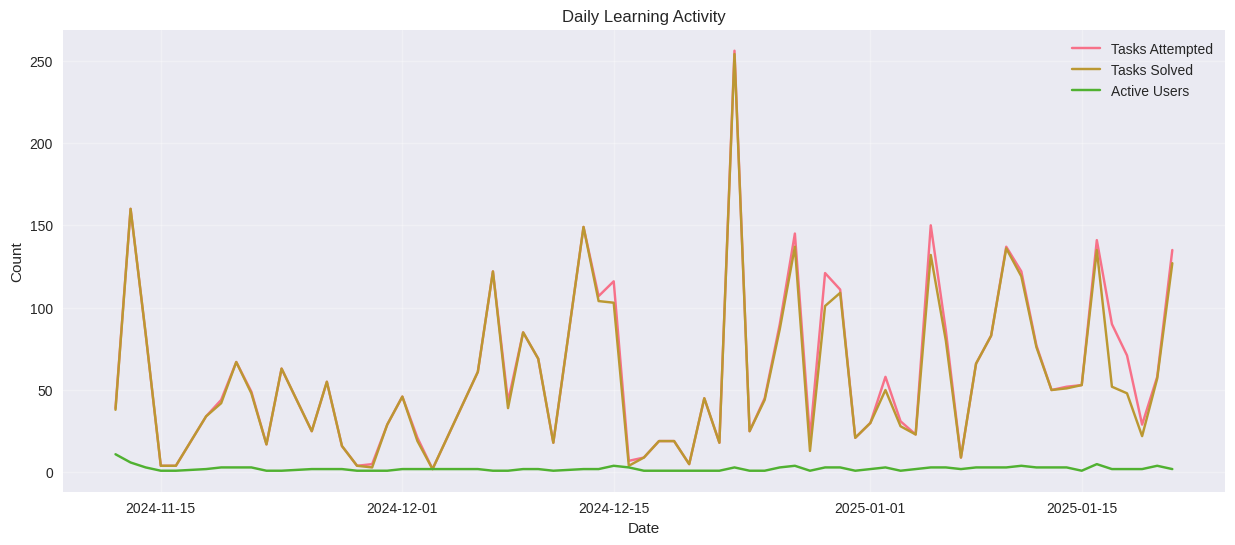


Verification of counts:
Total attempts: 4,046
Total solutions: 3,847


In [54]:
# Calculate daily/weekly progress metrics
time_metrics = raw_df.copy()
time_metrics['date'] = time_metrics['timestamp'].dt.date

daily_attempts = time_metrics.groupby('date').agg({
    'task_id': 'count',
    'user_id': 'nunique',
})

daily_solutions = time_metrics[time_metrics['is_solution']].groupby('date').agg({
    'task_id': 'count',
})

daily_stats = daily_attempts.join(daily_solutions['task_id'], rsuffix='_solved').fillna(0).reset_index()
daily_stats.columns = ['date', 'attempts', 'active_users', 'solutions']

plt.figure(figsize=(15, 6))
plt.plot(daily_stats['date'], daily_stats['attempts'], label='Tasks Attempted')
plt.plot(daily_stats['date'], daily_stats['solutions'], label='Tasks Solved')
plt.plot(daily_stats['date'], daily_stats['active_users'], label='Active Users')
plt.title('Daily Learning Activity')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nVerification of counts:")
print(f"Total attempts: {daily_stats['attempts'].sum():,}")
print(f"Total solutions: {daily_stats['solutions'].sum():,}")